In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)

3.1.0


---

## Load Traffic Lights data



In [3]:
from data_utils import load_tl_extracts

In [4]:
desired_dim = (32,32)

In [5]:
data_dirs = ['data/tl-extract-train', 'data/tl-extract-test', 'data/tl-extract-additional']

In [6]:
# OpenCV uses H, W, C. and C is ordered BGR
x, y = load_tl_extracts(data_dirs, desired_dim)

In [7]:
x.shape

(24504, 32, 32, 3)

In [8]:
y.shape

(24504,)

In [9]:
y_set = set(y)
y_dict = {y: i for i,y in enumerate(y_set)}
y_n = [y_dict[el] for el in y]
n_classes = len(y_set)

---

## Filter only classes relevant for us



{'green': 8,
 'greenleft': 12,
 'greenright': 9,
 'greenstraight': 7,
 'greenstraightleft': 0,
 'greenstraightright': 5,
 'off': 1,
 'red': 4,
 'redleft': 11,
 'redright': 6,
 'redstraight': 10,
 'redstraightleft': 3,
 'yellow': 2}

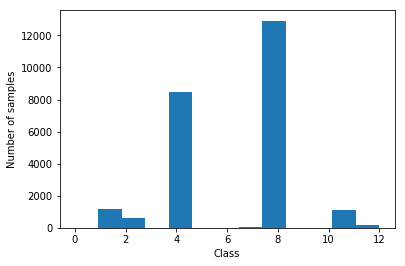

In [10]:
#distribution of examples per class
plt.hist(y_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y_dict

In [11]:
relevant = ['green','off','yellow','red']
x2 = x[np.isin(y, relevant)]
y2 = y[np.isin(y, relevant)]

In [12]:
x2.shape

(23164, 32, 32, 3)

In [13]:
y2_set = set(y2)
y2_dict = {y: i for i,y in enumerate(y2_set)}
y2_n = [y_dict[el] for el in y2]
n_classes = len(y2_set)

{'green': 0, 'off': 1, 'red': 2, 'yellow': 3}

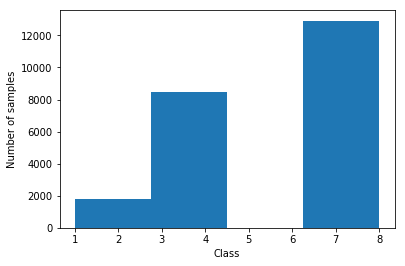

In [14]:
#distribution of examples per class
plt.hist(y2_n, bins=n_classes);
plt.xlabel('Class');
plt.ylabel('Number of samples');
y2_dict

---

## Visualize Data



In [15]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

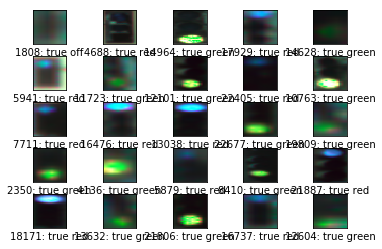

In [16]:
# randomly show grid 5x5 examples from training data set and their true class
rows = 5
cols = 5
cls = None
show_images(x2, y2, rows, cols, cls)

----

## Preprocess and split train/test


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [18]:
x = x2
y = y2

In [19]:
# apply One-Hot Encoding for class labels. at the moment they are integers 0..42
encoder = LabelBinarizer()
encoder.fit(y)
y_onehot = encoder.transform(y)
# Change to float32, so it can be multiplied against the features in 
# TensorFlow, which are float32
y_onehot = y_onehot.astype(np.float32)

In [20]:
pct_train = 85.
pct_valid = 15.
random_state = 123

train_features, val_features, train_labels, val_labels = train_test_split(
                                                            x, y_onehot, 
                                                            train_size = pct_train/100., 
                                                            test_size = pct_valid/100.,
                                                            random_state = random_state)

In [21]:
train_features.shape

(19689, 32, 32, 3)

In [22]:
train_features.dtype

dtype('uint8')

In [23]:
train_labels.shape

(19689, 4)

----

## Design and Test a Model Architecture


Below is Tensorboard visualisation of the main part of my network (before softmax).

Here is the description of it:

1. input features. shape: (?, 32, 32, 3)
2. convolution. kernel: [5,5] 3 input channels, 64 output channels. strides [1,1,1,1]. SAME padding.
3. add bias
4. relu
5. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
6. convolution. kernel: [5,5] 64 input channels, 32 output channels. strides [1,1,1,1]. SAME padding.
7. add bias
8. relu
9. max pool. strides [1,2,2,1]. kernel [1,2,2,1]. SAME padding
10. reshape to flatten features. 2048 features
11. dropout with keep_probability=0.5
12. fully connected W*x+bias. output: number of classes
13. softmax to get label probabilities

.

In [24]:
#from IPython.display import Image
#Image('CNN-graph.png')

In [25]:
from tl_classifier_cnn import TLClassifierCNN

In [26]:
# define shapes
features_shape = ((None,) + train_features.shape[1:])
labels_shape = (None,train_labels.shape[1],)

In [27]:
# create classifier
tsc = TLClassifierCNN()

# define model
tsc.define_model(features_shape=features_shape, labels_shape=labels_shape)

In [28]:
# where we save trained variables
model_param_file = 'ckpt/model.ckpt'

# where we save graph and events/summaries for tensorflow
summary_dir = 'train_summaries'

tsc.set_save_files(model_param_file, summary_dir)

In [38]:
# learning parameters
epochs = 50
batch_size = 250
learning_rate = 0.001
max_iterations_without_improvement = 10
dropout_keep_probability=0.7

In [39]:
# create Tensorflow session
tsc.create_session(learning_rate)

In [40]:
# i have trained model several times, restarting from where I left off, sometimes changing parameters
tsc.restore_variables()

INFO:tensorflow:Restoring parameters from ckpt/model.ckpt-1501


In [41]:
# main training
loss_epoch, train_acc_epoch, valid_acc_epoch, best_validation_accuracy = \
    tsc.train(train_images      = train_features, 
              train_labels      = train_labels, 
              validation_images = val_features, 
              validation_labels = val_labels, 
              dropout_keep_probability = dropout_keep_probability,
              batch_size        = batch_size, 
              epochs            = epochs, 
              max_iterations_without_improvement = max_iterations_without_improvement)

Val Accuracy Epoch 1502/50: 100%|██████████| 14/14 [00:00<00:00, 38.93batches/s]


epoch 1501, val accuracy: 0.9769784936801993
validation accuracy improved
checkpoint saved to ckpt/model.ckpt-1580


Train Epoch 1504/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1502, val accuracy: 0.9738130140647614


Val Accuracy Epoch 1504/50: 100%|██████████| 14/14 [00:00<00:00, 39.34batches/s]


epoch 1503, val accuracy: 0.9749640861003519


Train Epoch 1506/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1504, val accuracy: 0.9775540365589609
validation accuracy improved
checkpoint saved to ckpt/model.ckpt-1817


Train Epoch 1507/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1505, val accuracy: 0.9761151744307374


Train Epoch 1508/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1506, val accuracy: 0.9775540245522698


Train Epoch 1509/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1507, val accuracy: 0.9772662430358448


Train Epoch 1510/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1508, val accuracy: 0.9752518564677067


Train Epoch 1511/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1509, val accuracy: 0.9761151915831532


Train Epoch 1512/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1510, val accuracy: 0.9772662468951383


Train Epoch 1513/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1511, val accuracy: 0.9764029636657495


Train Epoch 1514/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1512, val accuracy: 0.9766907233128445


Train Epoch 1515/50:   0%|          | 0/79 [00:00<?, ?batches/s]

epoch 1513, val accuracy: 0.9764029473709546


Val Accuracy Epoch 1515/50: 100%|██████████| 14/14 [00:00<00:00, 38.70batches/s]

epoch 1514, val accuracy: 0.9758274036345722
no validation accuracy improvement over 10 epochs. stop
runtime: 0:12:21.434049
best val accuracy: 0.9775540365589609
epochs: 1514


In [ ]:
STOP

In [ ]:
# accuracy statistics for last epoch (train set and validation set). and also best seen validation set accuracy 
train_acc_epoch[-1], best_validation_accuracy

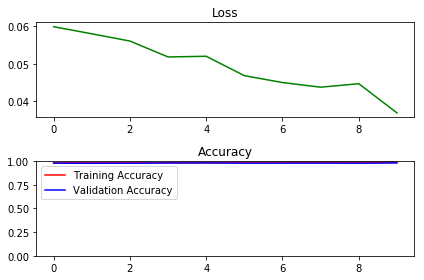

In [37]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(loss_epoch, 'g')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.legend(loc=2)
plt.tight_layout()
plt.show()

## investigating accuracy on out of sample data

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images=val_features, 
              true_labels=val_labels, 
              batch_size=150)


In [ ]:
accuracy

In [ ]:
# great, accuracy 99.74% on validation set.

In [ ]:
predicted_probabilities.shape

In [ ]:
predicted_probabilities[0]

In [ ]:
predicted_classes[0]

In [ ]:
certainty = predicted_probabilities.max(axis=1)

In [ ]:
plt.hist(certainty, bins=100);

In [ ]:
len(certainty[certainty<.98])

In [ ]:
plt.plot(certainty[certainty<.98]);

In [ ]:
# NOW test model predictions on test.p data which was not used in training or cross-validation

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x_test_norm, 
              true_labels = y_test_norm, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
# 95.64% accuracy. great! model generalises very well! lets analyse what is working and what is not.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_test_accuracy(images, cls_pred, cls_true, 
                        show_example_errors=False,
                        show_confusion_matrix=False):
    num_test = len(images)
    num_classes = len(set(cls_true))

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        incorrect = (correct == False)
        im = images[incorrect]
        cp = cls_pred[incorrect]
        ct = cls_true[incorrect]
        show_images(im, ct, 3, 4, labels_predicted=cp, random=False)
                
    if show_confusion_matrix:
        print("Confusion Matrix (log):")
        # Get the confusion matrix using sklearn.
        cm = confusion_matrix(y_true=cls_true,
                              y_pred=cls_pred)
        #print(cm)
        plt.matshow(np.log(cm))
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes))
        plt.yticks(tick_marks, range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()        

In [ ]:
# lets look at first 26x26 cells of confusion matrix
cm = confusion_matrix(y_true=y_test,
                      y_pred=predicted_classes)
np.set_printoptions(threshold=np.nan, linewidth=200)
print(cm[:25,:25])
np.set_printoptions(threshold=30, linewidth=75)

In [ ]:
# visualize example error images and confusion matrix
print_test_accuracy(images=X_test, 
                    cls_pred=predicted_classes, 
                    cls_true=y_test, 
                    show_example_errors=True, 
                    show_confusion_matrix=True)

In [ ]:
# read the sign names into a dict
import csv
reader = csv.DictReader(open('signnames.csv'))
signnames = {}
for row in reader:
    signnames[int(row['ClassId'])] = row['SignName']    

In [ ]:
# visualize instances where model is misclassifying big number of images

In [ ]:
def print_one_confusion(images, true_labels, predicted_labels, show_true_class, show_false_class):
    idx = np.logical_and(true_labels==show_true_class, predicted_labels==show_false_class)
    cnt = sum(idx)
    print('true class "{}", predicted class "{}". found: {}'.format(signnames[show_true_class], signnames[show_false_class], cnt))
    cols = int(np.ceil(cnt/10))
    show_images(images[idx], true_labels[idx], cols, 10, random=False, labels_predicted=predicted_labels[idx])

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=21, show_false_class=12)
# what we see here is the same test set image (may be with small transformations) that was misclassified.
# this seems like a genuine defficiency of the model -- the predicted sign is very different visually than the image

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=30, show_false_class=23)
# with this one it looks like the same image, with slight transformations. the quality is quite poor, so its 
# understandable that model had hard time predicting it. the shape of the sign is actually right. and the picture
# inside triangle is not very legible even for a human, so this is probably ok

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=7, show_false_class=5)
# we see in confusion matrix that all the speed limit signs have high misclassification errors between them.
# looks like the quality of the picture need to increase (better resolution is required)
# for model to be more discerning between different speed limits.

In [ ]:
print_one_confusion(images=X_test, true_labels=y_test, predicted_labels=predicted_classes, 
                    show_true_class=6, show_false_class=42)
# looks like in this case the model is confused by the 'end' part -- the line across the sign. so it used the shape
# and the cross line as main features. it also interpreted 80 as two vehicles passing each other (see below for
# images of the 'end of passing' sign examples)

In [ ]:
rows = 3
cols = 10
cls = 42
show_images(X_test, y_test, rows, cols, cls)

In [ ]:
x = normalize_data(im_array)
y = encoder.transform(im_true_label)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
predicted_probabilities, predicted_classes, accuracy = \
  tsc.predict(images = x, 
              true_labels = y, 
              batch_size = 150)


In [ ]:
accuracy

In [ ]:
predicted_classes

In [ ]:
im_true_label

In [ ]:
rows = 3
cols = 10
cls = 11
show_images(X_test, y_test, rows, cols, cls)

In [ ]:
tsc.close_session()